使用很少的数据来训练一个图像分类模型，这是很常见的情况，如果你要从事计算机视觉方面的职业，很可能会在实践中遇到这种情况。“很少的”样本可能是几百张图像，也可能是几万张图像。来看一个实例，我们将重点讨论猫狗图像分类，数据集中包含4000张猫和狗的图像（2000张猫的图像，2000张狗的图像）。我们将2000张图像用于训练，1000张用于验证，1000张用于测试。

本节将介绍解决这一问题的基本策略，即**使用已有的少量数据从头开始训练一个新模型**。

* 首先，在`2000`个训练样本上训练一个简单的小型卷积神经网络，不做任何正则化，为模型目标设定一个基准。这会得到`71%` 的分类精度。此时主要的问题在于**过拟合**。

* 然后，我们会介绍**数据增强（data augmentation）**，它在计算机视觉领域是一种非常强大的降低过拟合的技术。使用数据增强之后，网络精度将提高到`82%`。介绍将深度学习应用于**小型数据集**的另外两个重要技巧： 
    * **用预训练的网络做特征提取（得到的精度范围在`90%~96%`）**
    * **对预训练的网络进行微调（最终精度为`97%`）**

总而言之，这三种策略——**从头开始训练一个小型模型、使用预训练的网络做特征提取、对预训练的网络进行微调**——构成了你的工具箱，未来可用于解决小型数据集的图像分类问题。

# 1 深度学习与小数据问题的相关性

有时你会听人说，**仅在有大量数据可用时，深度学习才有效**。这种说法部分正确：**深度学习的一个基本特性就是能够独立地在训练数据中找到有趣的特征，无须人为的特征工程，而这只在拥有大量训练样本时才能实现**。**对于输入样本的维度非常高（比如图像）的问题尤其如此**。

但对于初学者来说，**所谓“大量”样本是相对的，即相对于你所要训练网络的大小和深度而言**。只用几十个样本训练卷积神经网络就解决一个复杂问题是不可能的，**但如果模型很小，并做了很好的正则化，同时任务非常简单，那么几百个样本可能就足够了**。

* 由于**卷积神经网络学到的是局部的、平移不变的特征，它对于感知问题可以高效地利用数据**。

* **虽然数据相对较少，但在非常小的图像数据集上从头开始训练一个卷积神经网络，仍然可以得到不错的结果，而且无须任何自定义的特征工程**。

此外，**深度学习模型本质上具有高度的可复用性**，比如，**已有一个在大规模数据集上训练的图像分类模型或语音转文本模型，你只需做很小的修改就能将其复用于完全不同的问题**。特别是在计算机视觉领域，许多预训练的模型（通常都是在 ImageNet数据集上训练得到的）现在都可以公开下载，并可以用于在数据很少的情况下构建强大的视觉模型。

# 2 下载加载数据

本节用到的猫狗分类数据集不包含在 Keras 中。 https://www.kaggle.com/c/dogs-vs-cats/data 下载原始数据集。2013 年的猫狗分类 Kaggle 竞赛的优胜者使用的是卷积神经网络。最佳结果达到了 95% 的精度。

这个数据集包含25000张猫狗图像（每个类别都有12500张），大小为543MB（压缩后）。下载数据并解压之后，你需要创建一个新数据集，其中包含三个子集：每个类别各1000个样本的训练集、每个类别各500个样本的验证集和每个类别各500个样本的测试集。

In [1]:
import os, shutil
# 原始数据集解压目录的路径
original_dataset_dir = 'D:\git\deep-learning-with-python\data\kaggle_original_data'

# 保存较小数据集的目录
base_dir = 'D:\git\deep-learning-with-python\data\cats_and_dogs_small'
os.mkdir(base_dir)

# 分别对应划分后的训练、验证和测试的目录
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# 猫的训练图像目录
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

# 狗的训练图像目录
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# 猫的验证图像目录
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

# 狗的验证图像目录
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# 猫的测试图像目录
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

# 狗的测试图像目录
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

# 将前 1000 张猫的图像复制到 train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# 将接下来 500 张猫的图像复制到 validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# 将接下来的 500 张猫的图像复制到 test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# 将前 1000 张狗的图像复制到 train_cats_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# 将接下来 500 张狗的图像复制到 validation_cats_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# 将接下来的 500 张狗的图像复制到 test_cats_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [2]:
# 看看每个分组（训练 / 验证 / 测试）中分别包含多少张图像
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


# 3 构建网络

在前一个 MNIST 示例中，我们构建了一个小型卷积神经网络，我们将复用相同的总体结构，即卷积神经网络由 Conv2D 层（使用 relu 激活）和MaxPooling2D 层交替堆叠构成。

但由于这里要处理的是更大的图像和更复杂的问题，你需要相应地增大网络，即再增加一个 Conv2D+MaxPooling2D 的组合。这既可以增大网络容量，也可以进一步减小特征图的尺寸，使其在连接 Flatten 层时尺寸不会太大。

本例中初始输入的尺寸为 150×150（有些随意的选择），所以最后在 Flatten 层之前的特征图大小为 7×7。

> 注意 网络中特征图的深度在逐渐增大（从 32 增大到 128），而特征图的尺寸在逐渐减小（从150×150 减小到 7×7）。这几乎是所有卷积神经网络的模式。

In [3]:
# 将猫狗分类的小型卷积神经网络实例化
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Using TensorFlow backend.


In [4]:
# 看一下特征图的维度如何随着每层变化
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [5]:
# 输出网络结构图
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='../img/05/cnn_model_dog_cat.png', show_layer_names=True, show_shapes=True)

In [6]:
# 配置模型用于训练
from keras import optimizers
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

# 4 数据预处理

将数据输入神经网络之前，应该将数据格式化为经过预处理的浮点数张量。现在，数据以 JPEG 文件的形式保存在硬盘中，所以数据预处理步骤大致如下。

* (1) 读取图像文件。
* (2) 将 JPEG 文件解码为 RGB 像素网格。
* (3) 将这些像素网格转换为浮点数张量。
* (4) 将像素值（0~255 范围内）缩放到 [0, 1] 区间（正如你所知，神经网络喜欢处理较小的输入值）。

这些步骤可能看起来有点吓人，但幸运的是， Keras 拥有自动完成这些步骤的工具。 **Keras有一个图像处理辅助工具的模块**，位于 `keras.preprocessing.image`。特别地，它包含`ImageDataGenerator`类，**可以快速创建`Python`生成器**，能够将硬盘上的图像文件自动转换为预处理好的张量批量。

In [7]:
from keras.preprocessing.image import ImageDataGenerator

# 将所有图像乘以 1/255 缩放
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 目标目录
        train_dir,
        # 将所有图像的大小调整为 150×150
        target_size=(150, 150),
        batch_size=20,
        # 因为使用了 binary_crossentropy损失，所以需要用二进制标签
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


其中一个生成器的输出：它生成了`150×150`的`RGB`图像`［形状为 (20,150, 150, 3)］`与二进制标签`［形状为 (20,)］`组成的批量。**每个批量中包含`20`个样本（批量大小）**。注意，生成器会不停地生成这些批量，它会不断循环目标文件夹中的图像。因此，你**需要在某个时刻终止`（break）`迭代循环**。

In [8]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


**利用生成器，我们让模型对数据进行拟合**。

我们将使用 `fit_generator` 方法来拟合，它在数据生成器上的效果和 `fit`相同。

它的第一个参数应该是一个 `Python` 生成器，可以不停地生成输入和目标组成的批量，比如 `train_generator`。因为数据是不断生成的，所以 `Keras` 模型要知道每一轮需要从生成器中抽取多少个样本。这是 `steps_per_epoch` 参数的作用：从生成器中抽取 `teps_per_epoch` 个批量后（即运行了 `steps_per_epoch` 次梯度下降），拟合过程将进入下一个轮次。

本例中，每个批量包含 `20` 个样本，所以读取完所有 `2000` 个样本需要 `100`个批量。

使用 `fit_generator` 时，你可以传入一个 `validation_data` 参数，其作用和在 `fit` 方法中类似。值得注意的是，这个参数可以是一个数据生成器，但也可以是 `Numpy` 数组组成的元组。如果向 `validation_data` 传入一个生成器，那么这个生成器应该能够不停地生成验证数据批量，因此你还需要指定 `validation_steps` 参数，说明需要从验证生成器中抽取多少个批次用于评估。

In [9]:
# 利用批量生成器拟合模型
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 21s 209ms/step - loss: 0.6909 - acc: 0.5335 - val_loss: 0.6726 - val_acc: 0.6160
Epoch 2/30
100/100 [==============================] - 15s 145ms/step - loss: 0.6672 - acc: 0.5840 - val_loss: 0.6621 - val_acc: 0.5820
Epoch 3/30
100/100 [==============================] - 15s 149ms/step - loss: 0.6367 - acc: 0.6380 - val_loss: 0.6212 - val_acc: 0.6660
Epoch 4/30
100/100 [==============================] - 14s 142ms/step - loss: 0.5921 - acc: 0.6855 - val_loss: 0.6501 - val_acc: 0.6110
Epoch 5/30
100/100 [==============================] - 14s 143ms/step - loss: 0.5556 - acc: 0.7110 - val_loss: 0.5881 - val_acc: 0.6850
Epoch 6/30
100/100 [==============================] - 14s 142ms/step - loss: 0.5182 - acc: 0.7465 - val_loss: 0.6013 - val_acc: 0.6760
Epoch 7/30
100/100 [==============================] - 14s 143ms/step - loss: 0.4797 - acc: 0.7740 - val_loss: 0.5630 - val_acc: 0.7120
Epoch 8/30
100/100 [==============================] - 1

In [10]:
# 始终在训练完成后保存模型，这是一种良好实践
# 保存模型
model.save('cats_and_dogs_small_1.h5')

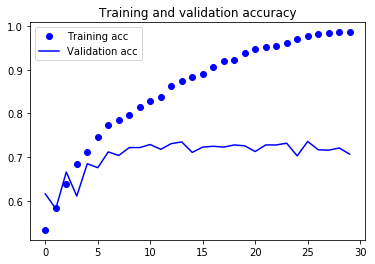

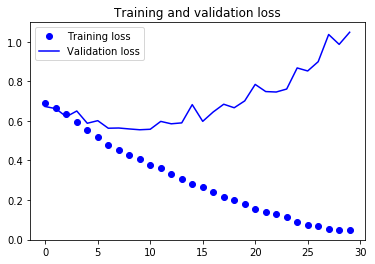

In [11]:
# 绘制训练过程中模型在训练数据和验证数据上的损失和精度
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

从这些图像中都能看出过拟合的特征。
* 训练精度随着时间线性增加，直到接近`100%`，而验证精度则停留在`70%~72%`。
* 验证损失仅在`5`轮后就达到最小值，然后保持不变，而训练损失则一直线性下降，直到接近于`0`。

因为训练样本相对较少（`2000`个），所以过拟合是你最关心的问题。

前面已经介绍过几种降低过拟合的技巧，比如`dropout`和`权重衰减（L2 正则化）`。

现在我们将使用一种针对于计算机视觉领域的新方法，在用深度学习模型处理图像时几乎都会用到这种方法，它就是数据增强`（data augmentation）`。

# 5 使用数据增强

过拟合的原因是学习样本太少，导致无法训练出能够泛化到新数据的模型。如果拥有无限的数据，那么模型能够观察到数据分布的所有内容，这样就永远不会过拟合。

**数据增强是从现有的训练样本中生成更多的训练数据**，其方法是**利用多种能够生成可信图像的随机变换来增加（augment）样本**。其目标是，**模型在训练时不会两次查看完全相同的图像。这让模型能够观察到数据的更多内容，从而具有更好的泛化能力**。

在 Keras 中，这可以通过对`ImageDataGenerator`实例读取的图像执行多次随机变换来实现。

In [12]:
# 利用 ImageDataGenerator 来设置数据增强

datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

这里只选择了几个参数（想了解更多参数，请查阅 Keras 文档）。我们来快速介绍一下这些参数的含义。

* rotation_range 是角度值（在 0~180 范围内），表示图像随机旋转的角度范围。
* width_shift 和 height_shift 是图像在水平或垂直方向上平移的范围（相对于总宽度或总高度的比例）。
* shear_range 是随机错切变换的角度。
* zoom_range 是图像随机缩放的范围。
* horizontal_flip 是随机将一半图像水平翻转。如果没有水平不对称的假设（比如真实世界的图像），这种做法是有意义的。
* fill_mode是用于填充新创建像素的方法，这些新像素可能来自于旋转或宽度/高度平移。

我们来看一下增强后的图像

![image.png](../img/05/通过随机数据增强生成的猫图像.png)

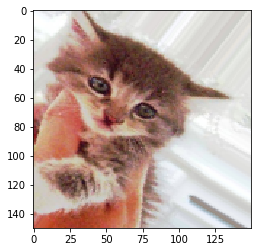

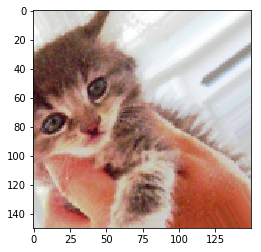

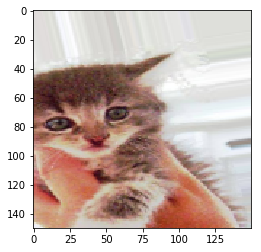

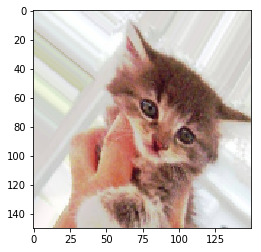

In [13]:
# 显示几个随机增强后的训练图像
# 图像预处理工具的模块
from keras.preprocessing import image
fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# 选择一张图像进行增强
img_path = fnames[3]

# 读取图像并调整大小
img = image.load_img(img_path, target_size=(150, 150))

# 将其转换为形状 (150, 150, 3) 的 Numpy 数组
x = image.img_to_array(img)

# 将其形状改变为 (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# 生成随机变换后的图像批量。循环是无限的，因此你需要在某个时刻终止循环
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

如果你使用这种数据增强来训练一个新网络，那么网络将不会两次看到同样的输入。但网络看到的输入仍然是高度相关的，因为这些输入都来自于少量的原始图像。你无法生成新信息，而只能混合现有信息。因此，这种方法可能不足以完全消除过拟合。为了进一步降低过拟合，你还需要向模型中添加一个 Dropout 层，添加到全连接分类器之前。

In [ ]:
# 定义一个包含 dropout 的新卷积神经网络
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

# 训练这个使用了数据增强和 dropout 的网络
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# 注意，不能增强验证数据
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 目标目录
        train_dir,
        # 将所有图像的大小调整为 150×150
        target_size=(150, 150),
        batch_size=32,
        # 因为使用了 binary_crossentropy损失，所以需要用二进制标签
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 43s 431ms/step - loss: 0.6914 - acc: 0.5222 - val_loss: 0.6764 - val_acc: 0.5311
Epoch 2/100
100/100 [==============================] - 41s 406ms/step - loss: 0.6686 - acc: 0.5837 - val_loss: 0.6474 - val_acc: 0.6057
Epoch 3/100
100/100 [==============================] - 38s 378ms/step - loss: 0.6575 - acc: 0.6003 - val_loss: 0.6331 - val_acc: 0.6269
Epoch 4/100
100/100 [==============================] - 36s 358ms/step - loss: 0.6432 - acc: 0.6172 - val_loss: 0.6234 - val_acc: 0.6443
Epoch 5/100
100/100 [==============================] - 34s 339ms/step - loss: 0.6252 - acc: 0.6388 - val_loss: 0.5989 - val_acc: 0.6707
Epoch 6/100
100/100 [==============================] - 39s 388ms/step - loss: 0.6119 - acc: 0.6706 - val_loss: 0.6691 - val_acc: 0.6340
Epoch 7/100
100/100 [==============================] - 51s 509ms/step - loss: 0.6082 - acc: 0.6588 -

In [ ]:
# 保存模型
model.save('cats_and_dogs_small_2.h5')

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

我们再次绘制结果（见图 5-12 和图 5-13）。使用了数据增强和 dropout 之后，模型不再过拟合：训练曲线紧紧跟随着验证曲线。现在的精度为 82%，比未正则化的模型提高了 15%（相对比例）。

通过进一步使用正则化方法以及调节网络参数（比如每个卷积层的过滤器个数或网络中的层数），你可以得到更高的精度，可以达到 86%或 87%。但只靠从头开始训练自己的卷积神经网络，再想提高精度就十分困难，因为可用的数据太少。想要在这个问题上进一步提高精度，下一步需要使用预训练的模型，这是接下来两节的重点。